In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from mlxtend.association import apriori
from mlxtend.preprocessing import OnehotTransactions
from scipy import stats


# Pandas Printing Options
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sns.set_style('white')

### get data

In [4]:
!wget -O - 'https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD' > nypd_motor_vehicle_collision.csv

--2017-06-20 01:16:39--  https://data.cityofnewyork.us/api/views/h9gi-nx95/rows.csv?accessType=DOWNLOAD
正在解析主机 data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.68.26
正在连接 data.cityofnewyork.us (data.cityofnewyork.us)|52.206.68.26|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度： 未指定 [text/csv]
正在保存至: “STDOUT”

-                       [        <=>         ] 224.94M  2.76MB/s    in 82s     

无效的“Last-modified”文件头 -- 忽略时间戳标记。
2017-06-20 01:18:01 (2.74 MB/s) - 已写入标准输出 [235870935]



### load data

In [7]:
data = pd.read_csv("nypd_motor_vehicle_collision.csv", low_memory=False)

### datetime column

In [8]:
data['DATE'] = pd.to_datetime(data['DATE'] + ' ' + data['TIME'])

### SET DATETIME AS INDEX

In [9]:
data = data.set_index('DATE')

### data information

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1052350 entries, 2017-06-10 00:00:00 to 2012-07-01 09:59:00
Data columns (total 28 columns):
TIME                             1052350 non-null object
BOROUGH                          768929 non-null object
ZIP CODE                         768865 non-null object
LATITUDE                         847518 non-null float64
LONGITUDE                        847518 non-null float64
LOCATION                         847518 non-null object
ON STREET NAME                   868326 non-null object
CROSS STREET NAME                836701 non-null object
OFF STREET NAME                  152114 non-null object
NUMBER OF PERSONS INJURED        1052350 non-null int64
NUMBER OF PERSONS KILLED         1052350 non-null int64
NUMBER OF PEDESTRIANS INJURED    1052350 non-null int64
NUMBER OF PEDESTRIANS KILLED     1052350 non-null int64
NUMBER OF CYCLIST INJURED        1052350 non-null int64
NUMBER OF CYCLIST KILLED         1052350 non-null int64
NUMBER OF M

In [16]:
print(data.index.min())
print(data.index.max())

2012-07-01 01:10:00
2017-06-10 21:40:00


### select data with pedestrians injury

In [12]:
data = data[data['NUMBER OF PEDESTRIANS INJURED']!=0]

In [13]:
data.shape

(52337, 28)

### monthly and daily data

In [19]:
monthly_injured = data.resample('M')['NUMBER OF PEDESTRIANS INJURED'].sum()
monthly_injured[:12]

DATE
2012-07-31     854
2012-08-31     850
2012-09-30     893
2012-10-31     979
2012-11-30    1037
2012-12-31    1294
2013-01-31    1113
2013-02-28     984
2013-03-31     987
2013-04-30     901
2013-05-31     982
2013-06-30     972
Freq: M, Name: NUMBER OF PEDESTRIANS INJURED, dtype: int64

In [21]:
daily_injured = data.resample('D')['NUMBER OF PEDESTRIANS INJURED'].sum()
daily_injured[:30]

DATE
2012-07-01    30
2012-07-02    30
2012-07-03    36
2012-07-04    20
2012-07-05    28
2012-07-06    34
2012-07-07    27
2012-07-08    16
2012-07-09    24
2012-07-10    42
2012-07-11    26
2012-07-12    32
2012-07-13    28
2012-07-14    31
2012-07-15    15
2012-07-16    23
2012-07-17    33
2012-07-18    25
2012-07-19    34
2012-07-20    23
2012-07-21    25
2012-07-22    25
2012-07-23    24
2012-07-24    23
2012-07-25    31
2012-07-26    33
2012-07-27    30
2012-07-28    23
2012-07-29    13
2012-07-30    33
Freq: D, Name: NUMBER OF PEDESTRIANS INJURED, dtype: int64

### daily data description

In [22]:
daily_injured.describe()

count   1806.000
mean      30.946
std       13.184
min        3.000
25%       23.000
50%       29.000
75%       36.750
max      226.000
Name: NUMBER OF PEDESTRIANS INJURED, dtype: float64

### monthly and daily injury by borough

In [23]:
borough_injuries_month = data.groupby([data.index.month, data.BOROUGH])['NUMBER OF PEDESTRIANS INJURED'].sum().unstack()

In [24]:
borough_injuries_daily = data.groupby([data.index.day, data.BOROUGH])['NUMBER OF PEDESTRIANS INJURED'].sum().unstack()

In [25]:
borough_by_biggest_population = ['MANHATTAN', 'BROOKLYN', 'QUEENS', 'BRONX', 'STATEN ISLAND']
borough_injuries_month = borough_injuries_month[borough_by_biggest_population]

In [26]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
months_abbr = [m[:3] for m in months]

borough_injuries_month.index = months
borough_injuries_month

BOROUGH,MANHATTAN,BROOKLYN,QUEENS,BRONX,STATEN ISLAND
January,1162,1677,1182,699,159
February,1026,1170,774,579,122
March,993,1322,900,630,97
April,901,1185,748,594,91
May,992,1309,790,606,100
June,805,1073,673,498,84
July,909,1140,712,538,92
August,963,1209,723,530,93
September,949,1253,880,589,88
October,1096,1527,1105,677,124


### 按月份和区域在车祸受伤的人的柱形图

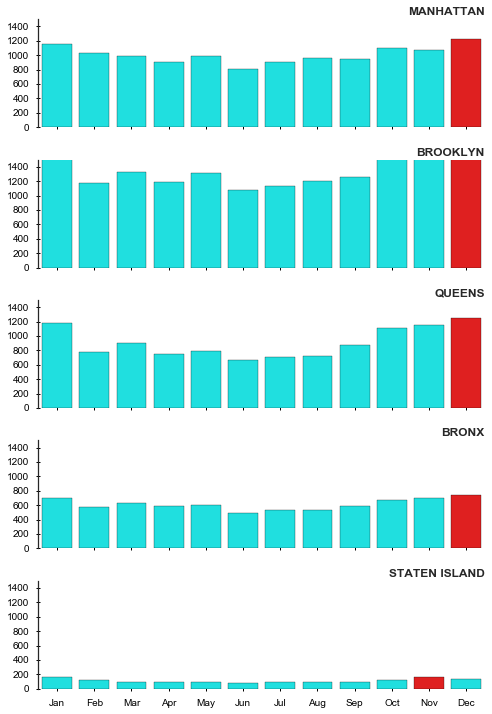

In [33]:
sns.set(style="white")

# Set up the matplotlib figure
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(8, 12), sharex=True, sharey=True)
f.subplots_adjust(hspace=.3)

for boro, ax in zip(borough_injuries_month, [ax1, ax2, ax3, ax4, ax5]):
    values = borough_injuries_month[boro].values
    colors = ['cyan' if (x < max(values)) else 'red' for x in values]
    sns.barplot(months_abbr, borough_injuries_month[boro], palette=colors, ax=ax)
    ax.set_title(boro, loc='right', weight='bold', fontdict={'fontsize': 12})
    ax.set_ylabel('')
    ax.tick_params(direction='inout', length=4, width=1, colors='black')
    sns.despine(bottom=True)

plt.ylim(0, 1500)
plt.show();

In [30]:
borough_injuries_daily

BOROUGH,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
1,252,506,416,344,48
2,211,573,358,318,43
3,270,558,390,397,38
4,274,537,331,365,65
5,216,582,383,327,40
6,245,567,414,381,47
7,259,536,407,415,39
8,228,513,388,366,38
9,215,520,373,336,39
10,218,568,443,366,60


In [35]:
data.head()

,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,UNIQUE KEY,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-06-10 13:47:00,13:47,BRONX,10461,40.849,-73.830,"(40.849194, -73.830444)",NaN,NaN,3100 WILLOW LANE,1,0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,3687833,PASSENGER VEHICLE,NaN,NaN,NaN,NaN
2017-06-10 14:05:00,14:05,BROOKLYN,11226,nan,nan,NaN,ROGERS AVENUE,CLARKSON AVENUE,NaN,1,0,1,0,0,0,0,0,Failure to Yield Right-of-Way,NaN,NaN,NaN,NaN,3687421,PASSENGER VEHICLE,NaN,NaN,NaN,NaN
2017-06-10 17:55:00,17:55,MANHATTAN,10009,40.729,-73.984,"(40.72878, -73.98446)",EAST 10 STREET,1 AVENUE,NaN,1,0,1,0,0,0,0,0,Failure to Yield Right-of-Way,NaN,NaN,NaN,NaN,3688654,BICYCLE,NaN,NaN,NaN,NaN
2017-06-10 18:27:00,18:27,MANHATTAN,10019,40.766,-73.987,"(40.765987, -73.98713)",WEST 54 STREET,9 AVENUE,NaN,1,0,1,0,0,0,0,0,Driver Inattention/Distraction,NaN,NaN,NaN,NaN,3688979,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,NaN
2017-06-10 20:30:00,20:30,BRONX,10454,40.810,-73.922,"(40.809776, -73.92241)",EAST 139 STREET,WILLIS AVENUE,NaN,1,0,1,0,0,0,0,0,Driver Inattention/Distraction,NaN,NaN,NaN,NaN,3688471,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,NaN


### 按周天和小时的车祸受伤数目

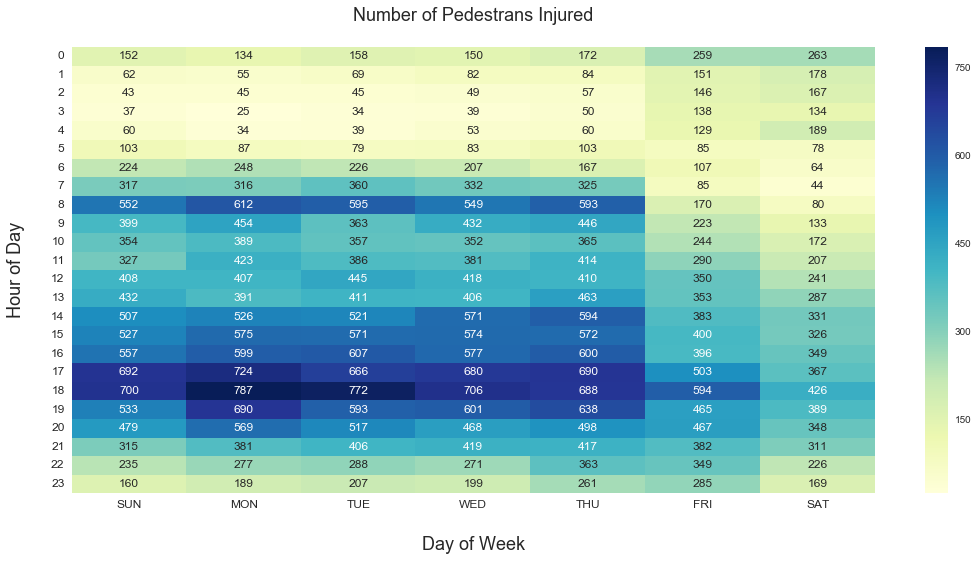

In [41]:
plt.figure(figsize=(18, 8))
dayofweek = data.groupby([data.index.dayofweek, data.index.hour])['NUMBER OF PEDESTRIANS INJURED'].sum().unstack().T
sns.heatmap(dayofweek, annot=True, fmt="d", cmap="YlGnBu")
plt.xticks(np.arange(7) + .5, ('SUN', 'MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT'))
plt.yticks(rotation=0)
plt.ylabel('Hour of Day\n', size=18)
plt.xlabel('\nDay of Week', size=18)
plt.yticks(rotation=0, size=12)
plt.xticks(rotation=0, size=12)
plt.title("Number of Pedestrans Injured\n", size=18, );

### 按小时和周-年的车祸受伤数目

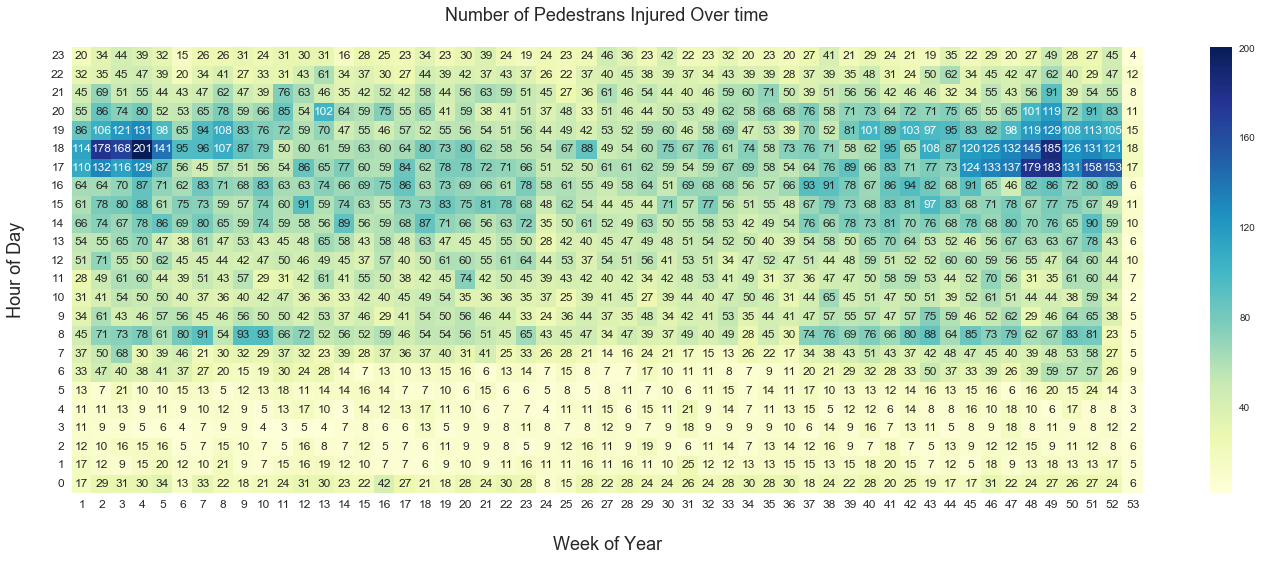

In [44]:
plt.figure(figsize=(24, 8))
hour_by_year = data.groupby([data.index.weekofyear, data.index.hour])['NUMBER OF PEDESTRIANS INJURED'].sum().unstack().T
hour_by_year = hour_by_year.iloc[::-1]
sns.heatmap(hour_by_year, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel('Hour of Day\n', size=18)
plt.xlabel('\nWeek of Year', size=18)
plt.yticks(rotation=0, size=12)
plt.xticks(rotation=0, size=12)
plt.title("Number of Pedestrans Injured Over time\n", size=18, );

### 受伤因素


In [46]:
contributing_factors = data[['CONTRIBUTING FACTOR VEHICLE 1',
                                 'CONTRIBUTING FACTOR VEHICLE 2',
                                 'CONTRIBUTING FACTOR VEHICLE 3',
                                 'CONTRIBUTING FACTOR VEHICLE 4',
                                 'CONTRIBUTING FACTOR VEHICLE 5']]

In [47]:
def filter_set(row):
    filtered = [element for element in row if str(element) != 'nan']
    filtered = [element for element in filtered if str(element) != 'Unspecified']
    return filtered

def my_generator(contributing_factors):
    for i in contributing_factors.as_matrix():
        if filter_set(i):
            yield filter_set(i)
            
def get_factors(dataset):
    oht = OnehotTransactions()
    oht_ary = oht.fit(dataset).transform(dataset)
    return pd.DataFrame(oht_ary, columns=oht.columns_)

In [48]:
factors_obj = my_generator(contributing_factors)
contributing_factors_to_injuries = [fact for fact in factors_obj]
df = get_factors(contributing_factors_to_injuries)

In [49]:
df.shape

(23384, 47)

In [51]:
results = apriori(df, min_support=0.0001, use_colnames=True)
results['count'] = results['support'] * df.shape[0]
results.head()

,support,itemsets,length,count
0,0.001,[Accelerator Defective],1,14.000
1,0.014,[Aggressive Driving/Road Rage],1,339.000
2,0.012,[Alcohol Involvement],1,288.000
3,0.073,[Backing Unsafely],1,1702.000
4,0.002,[Brakes Defective],1,49.000


In [52]:
reasons = df.sum().sort_values(ascending=False)[:10]
reasons

Driver Inattention/Distraction                           7493
Failure to Yield Right-of-Way                            6735
Backing Unsafely                                         1702
Passenger Distraction                                    1444
Other Vehicular                                           776
View Obstructed/Limited                                   541
Traffic Control Disregarded                               528
Glare                                                     512
Pedestrian/Bicyclist/Other Pedestrian Error/Confusion     427
Pavement Slippery                                         361
dtype: int64

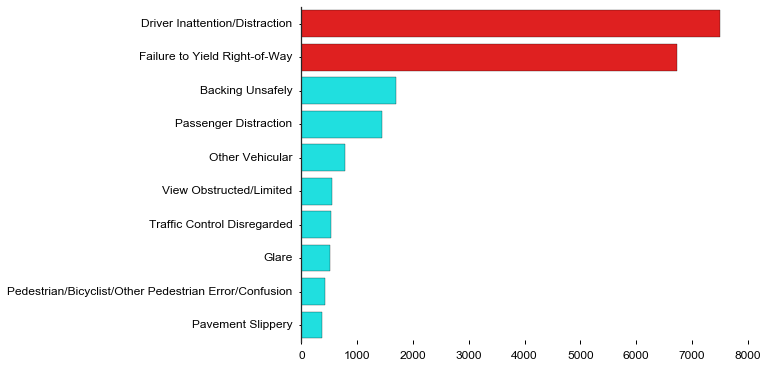

In [54]:
values = reasons.values
labels = reasons.index

plt.figure(figsize=(8, 6))
colors = ['cyan' if (x < 5000) else 'red' for x in values]
sns.barplot(reasons.values, labels, palette=colors)
plt.tick_params(direction='inout', length=4, width=1, colors='black')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
sns.despine(bottom=True)

### 受伤人数

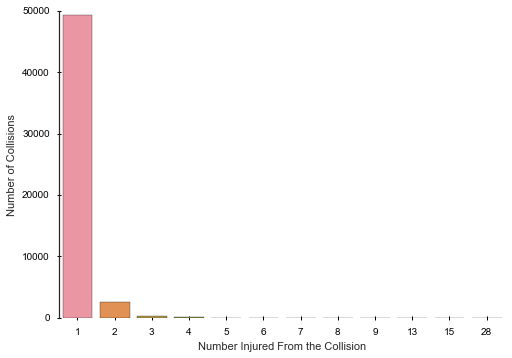

In [58]:
collision_to_num_injured_freq = stats.itemfreq(data['NUMBER OF PEDESTRIANS INJURED'])

labels = collision_to_num_injured_freq[:, 0]
values = collision_to_num_injured_freq[:, 1]

sns.barplot(labels, values)
plt.tick_params(direction='inout', length=4, width=1, colors='black')
plt.ylabel('Number of Collisions')
plt.xlabel('Number Injured From the Collision')
sns.despine(bottom=True)